<a href="https://colab.research.google.com/github/liuxiao916/Dive_into_DL_PyTorch/blob/main/3_6_softmax%E5%9B%9E%E5%BD%92%E7%9A%84%E4%BB%8E%E9%9B%B6%E5%BC%80%E5%A7%8B%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.6 softmax回归的从零开始实现


In [1]:
%matplotlib inline
import torch
import numpy as np

### 3.6.1 读取数据集

In [2]:
import torchvision
Batch_size =256
fashionmnist_train = torchvision.datasets.FashionMNIST(root = './data/fashionMNIST', train = True, transform=torchvision.transforms.ToTensor(),download=True)
fashionmnist_train_dataloader = torch.utils.data.DataLoader(dataset= fashionmnist_train,batch_size = Batch_size, shuffle = True)
fashionmnist_test = torchvision.datasets.FashionMNIST(root = './data/fashionMNIST', train = False, transform=torchvision.transforms.ToTensor(),download=True)
fashionmnist_test_dataloader = torch.utils.data.DataLoader(dataset= fashionmnist_test,batch_size = Batch_size, shuffle = True)


Extracting ./data/fashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashionMNIST/FashionMNIST/raw




Extracting ./data/fashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashionMNIST/FashionMNIST/raw




Extracting ./data/fashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashionMNIST/FashionMNIST/raw




Extracting ./data/fashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashionMNIST/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3.6.2 初始化模型参数

In [3]:
num_inputs =784
num_outputs = 10

W =  torch.from_numpy(np.random.normal(scale = 0.01, size = (num_inputs, num_outputs))).float()
b = torch.from_numpy(np.zeros(num_outputs)).float()

In [4]:
W.requires_grad_()
b.requires_grad_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 3.6.3 实现softmax运算

In [5]:
X = np.array([[1,2,3],[4,5,6]])
X.sum(axis = 0,keepdims=True) , X.sum(axis = 1,keepdims=True)

(array([[5, 7, 9]]), array([[ 6],
        [15]]))

In [6]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis=1,keepdims = True)
    return X_exp / partition    

In [7]:
X = torch.from_numpy(np.random.normal(size=(2,5)))
X_prob = softmax(X)
X_prob, X_prob.sum(axis = 1)

(tensor([[0.2224, 0.4360, 0.1423, 0.0337, 0.1657],
         [0.3543, 0.2146, 0.1616, 0.1575, 0.1119]], dtype=torch.float64),
 tensor([1.0000, 1.0000], dtype=torch.float64))

### 3.6.4 定义模型

In [8]:
def net(X):
    return softmax(torch.mm(X.reshape(-1,num_inputs),W)+b)

### 3.6.5 定义损失函数


In [9]:
y_hat = torch.from_numpy(np.array([[0.1,0.3,0.6],[0.3,0.2,0.5]]))
y = torch.from_numpy(np.array([0,2],dtype='int64'))
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]], dtype=torch.float64)

In [10]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat.gather(1, y.view(-1, 1)))

### 3.6.6 计算分类准确率

In [11]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [12]:
accuracy(y_hat,y)

0.5

In [13]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0 
    for X,y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n

In [14]:
evaluate_accuracy(fashionmnist_train_dataloader, net)

0.04565

### 3.6.7 训练模型

In [15]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data = param.data - lr*param.grad / batch_size

In [16]:
num_epoch = 5
lr = 0.1

def train_ch3(net, train_iter,test_iter, loss, num_epochs, batch_size, params = None, lr = None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n =0.0, 0.0, 0
        for X,y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            l.backward()
            sgd(params, lr, batch_size)
            
            for param in params:
                param.grad.data.zero_()

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, fashionmnist_train_dataloader,fashionmnist_test_dataloader, cross_entropy, num_epoch, Batch_size, [W,b], lr )

        

epoch 1, loss 0.7878, train acc 0.745, test acc 0.797
epoch 2, loss 0.5712, train acc 0.813, test acc 0.813
epoch 3, loss 0.5262, train acc 0.826, test acc 0.818
epoch 4, loss 0.5007, train acc 0.832, test acc 0.823
epoch 5, loss 0.4850, train acc 0.837, test acc 0.826


### 3.6.8 预测

In [17]:
def use_svg_display():
    from IPython import display
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

In [18]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[i] for i in labels]

In [27]:
def show_fashion_mnist(images, labels):
    import matplotlib.pyplot as plt
    use_svg_display()
    _, figs = plt.subplots(1, len(images), figsize =(12,12))
    for f , img , lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28,28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

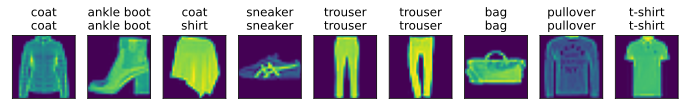

In [28]:
for X,y in fashionmnist_test_dataloader:
    true_labels = get_fashion_mnist_labels(y)
    pred_labels= get_fashion_mnist_labels(net(X).argmax(dim = 1).numpy())
    titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
    show_fashion_mnist(X[0:9],titles[0:9]) 
    break 
